## Predictive Modeling
*for Abusive Chat Detection project*

### Load Packages

In [72]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

import seaborn as sns

from pycaret.classification import *
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import re
import string

### Load Data

In [148]:
hate_df = pd.read_csv('Data/hate.csv')
offensive_df = pd.read_csv('Data/offensive.csv')

### Preprocess Data

Some of the tweets show as NaN, so we drop those rows.

In [74]:
# Drop NA rows
hate_df.dropna(subset=['Tweet'], inplace=True)
hate_df.reset_index(drop=True, inplace=True)
offensive_df.dropna(subset=['Tweet'], inplace=True)
offensive_df.reset_index(drop=True, inplace=True)

Here we remove numbers and punctuation in order to normalize the text a bit

In [75]:
def preprocess(sentences):
    # Remove Numbers
    sentences = [re.sub(r'\d+', '', s) for s in sentences]
    # Remove Punctuation
    sentences = ["".join([i for i in s if i not in string.punctuation]) for s in sentences]
    
    return sentences

hate_df['Tweet'] = preprocess(hate_df['Tweet'])
offensive_df['Tweet'] = preprocess(offensive_df['Tweet'])

## Prepare Hate Data for Modeling

In order to train a machine learning model on text data, we can't just use the sentences as features. We have to extract features. There's lots of methods for this, but the one I chose is vectorizing the sentence using TFID. This takes into account the frequency of each word in the sentence as well as the entire corpus. Prior to vectorizing the sentences, I split the data into train and test sets. 

In [76]:
hate_sentences_train, hate_sentences_test, hate_y_train, hate_y_test = train_test_split(
    hate_df['Tweet'], hate_df['Hate'], test_size = 0.25, random_state=1)

print('Train Proportions')
print('Not Hate: {:.2%}'.format(hate_y_train.value_counts()[0]/(hate_y_train.value_counts()[0]+hate_y_train.value_counts()[1])))
print('Hate: {:.2%}'.format(hate_y_train.value_counts()[1]/(hate_y_train.value_counts()[0]+hate_y_train.value_counts()[1])))
print()
print('Test Proportions')
print('Not Hate: {:.2%}'.format(hate_y_test.value_counts()[0]/(hate_y_test.value_counts()[0]+hate_y_test.value_counts()[1])))
print('Hate: {:.2%}'.format(hate_y_test.value_counts()[1]/(hate_y_test.value_counts()[0]+hate_y_test.value_counts()[1])))

hate_vectorizer = TfidfVectorizer(min_df=0, lowercase=True, stop_words=stop_words, max_features = 2000)
x_hate_train = hate_vectorizer.fit_transform(hate_sentences_train)
x_hate_test = hate_vectorizer.transform(hate_sentences_test)
count_vect_df = pd.DataFrame(x_hate_train.todense(), columns=hate_vectorizer.get_feature_names())
hate_y_train.reset_index(drop=True, inplace=True)
count_vect_df['Hate'] = hate_y_train

Train Proportions
Not Hate: 57.79%
Hate: 42.21%

Test Proportions
Not Hate: 58.07%
Hate: 41.93%


Finally, we set up the pycaret experiment with the 2000 features found with the TFID vectorizer. The features here are the top 2000 most frequent words in the corpus of tweet data. The values of the features are the term frequency inverse document frequency score.

In [77]:
clf = setup(count_vect_df, target='Hate')

,Description,Value
0,session_id,5399
1,Target,Hate
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(9721, 2001)"
5,Missing Values,False
6,Numeric Features,2000
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Hate Modeling

Here we run the compare_models() function from PyCaret to fit the training set to all the available models in the module.

In [7]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7213,0.7851,0.6388,0.6796,0.6584,0.4235,0.4243,9.8930
catboost,CatBoost Classifier,0.7185,0.7921,0.5620,0.7088,0.6265,0.4057,0.4129,39.3360
xgboost,Extreme Gradient Boosting,0.7162,0.7833,0.5868,0.6921,0.6347,0.4053,0.4093,18.5310
lightgbm,Light Gradient Boosting Machine,0.7143,0.7844,0.6116,0.6780,0.6428,0.4059,0.4075,0.7470
rf,Random Forest Classifier,0.7128,0.7878,0.6130,0.6752,0.6423,0.4034,0.4050,5.5850
lr,Logistic Regression,0.7091,0.7862,0.5592,0.6908,0.6176,0.3872,0.3931,1.0510
svm,SVM - Linear Kernel,0.7024,0.0000,0.5864,0.6660,0.6222,0.3788,0.3818,0.6170
ridge,Ridge Classifier,0.6981,0.0000,0.5980,0.6551,0.6249,0.3732,0.3746,0.4400
gbc,Gradient Boosting Classifier,0.6940,0.7634,0.4820,0.6974,0.5696,0.3445,0.3588,8.7450
ada,Ada Boost Classifier,0.6905,0.7416,0.5054,0.6774,0.5784,0.3421,0.3515,2.4160


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=4749, verbose=0,
                     warm_start=False)

The CatBoost Classifier has the highest AUC score so we will create a model with that.

In [78]:
catboost = create_model('catboost', cross_validation = False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7233,0.8077,0.557,0.7615,0.6434,0.4262,0.4401


In [79]:
save_model(catboost, 'catboost_hate_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Hate',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strateg...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Hate')),
                 ('fix_perfect', Remove_100(target='Hate')),
                 ('clean_names', Clea

## Prepare Offensive Data for Modeling

Now we will use the same process for Offensive Data.

In [80]:
offensive_sentences_train, offensive_sentences_test, offensive_y_train, offensive_y_test = train_test_split(
    offensive_df['Tweet'], offensive_df['Offensive'], test_size = 0.25, random_state=1)

print('Train Proportions')
print('Not offensive: {:.2%}'.format(offensive_y_train.value_counts()[0]/\
                                     (offensive_y_train.value_counts()[0]+offensive_y_train.value_counts()[1])))
print('Offensive: {:.2%}'.format(offensive_y_train.value_counts()[1]/\
                                 (offensive_y_train.value_counts()[0]+offensive_y_train.value_counts()[1])))
print()
print('Test Proportions')
print('Not offensive: {:.2%}'.format(offensive_y_test.value_counts()[0]/\
                                     (offensive_y_test.value_counts()[0]+offensive_y_test.value_counts()[1])))
print('Offensive: {:.2%}'.format(offensive_y_test.value_counts()[1]/\
                                 (offensive_y_test.value_counts()[0]+offensive_y_test.value_counts()[1])))

offensive_vectorizer = TfidfVectorizer(min_df=0, lowercase=True, stop_words=stop_words, max_features = 2000)
x_offensive_train = offensive_vectorizer.fit_transform(offensive_sentences_train)
x_offensive_test = offensive_vectorizer.transform(offensive_sentences_test)
count_vect_df = pd.DataFrame(x_offensive_train.todense(), columns=offensive_vectorizer.get_feature_names())
offensive_y_train.reset_index(drop=True, inplace=True)
count_vect_df['Offensive'] = offensive_y_train

Train Proportions
Not offensive: 67.21%
Offensive: 32.79%

Test Proportions
Not offensive: 66.75%
Offensive: 33.25%


In [81]:
clf = setup(count_vect_df, target='Offensive')

,Description,Value
0,session_id,6633
1,Target,Offensive
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(10575, 2001)"
5,Missing Values,False
6,Numeric Features,1998
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


## Offensive Modeling

In [47]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7624,0.7645,0.4943,0.6981,0.5782,0.4197,0.4320,16.5900
svm,SVM - Linear Kernel,0.7609,0.0000,0.4579,0.7170,0.5574,0.4049,0.4246,0.8490
ada,Ada Boost Classifier,0.7584,0.7092,0.3736,0.7807,0.5049,0.3707,0.4149,2.3690
rf,Random Forest Classifier,0.7583,0.7628,0.4064,0.7468,0.5260,0.3824,0.4144,10.9070
catboost,CatBoost Classifier,0.7579,0.7694,0.3598,0.7959,0.4950,0.3646,0.4144,35.4010
lr,Logistic Regression,0.7556,0.7690,0.3626,0.7797,0.4947,0.3610,0.4070,1.5690
xgboost,Extreme Gradient Boosting,0.7540,0.7516,0.3859,0.7477,0.5084,0.3662,0.4021,18.9290
ridge,Ridge Classifier,0.7534,0.0000,0.4665,0.6876,0.5554,0.3934,0.4079,0.5290
gbc,Gradient Boosting Classifier,0.7426,0.7366,0.2792,0.8279,0.4171,0.3009,0.3743,8.8440
lightgbm,Light Gradient Boosting Machine,0.7364,0.7201,0.3749,0.6844,0.4840,0.3270,0.3538,0.6850


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=7521, verbose=0,
                     warm_start=False)

The CatBoost Classifier has the highest AUC score so we will create a model with that.

In [82]:
catboost = create_model('catboost', cross_validation = False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7624,0.7705,0.3699,0.784,0.5026,0.3719,0.4172


In [83]:
save_model(catboost, 'catboost_offensive_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Offensive',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_st...
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Offensive')),
                 ('fix_perfect', Remove_100(target='Offensive')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthroug

## Evaluate Models

In [183]:
def report(actual, predicted):
    """
    Reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    """
    AUC = roc_auc_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    print('AUC: ', AUC)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    conf_matrix = confusion_matrix(actual, predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    return

In [85]:
# Load Model
hate_catboost = load_model('catboost_hate_model')

Transformation Pipeline and Model Successfully Loaded


In [86]:
# Prep Test df
count_vect_df = pd.DataFrame(x_hate_test.todense(), columns=hate_vectorizer.get_feature_names())
hate_y_test.reset_index(drop=True, inplace=True)
count_vect_df['Hate'] = hate_y_test

AUC:  0.7047179858916703
Accuracy:  0.7272446775686516
Precision:  0.7238454288407163
Recall:  0.565121412803532


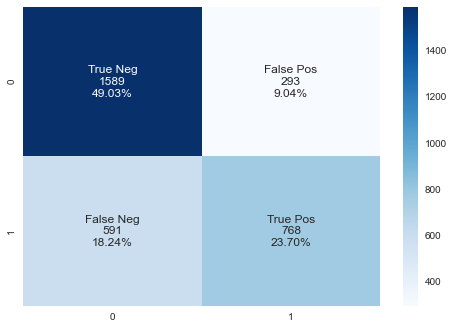

In [87]:
# Get Predictions
predictions = predict_model(hate_catboost, data=count_vect_df, probability_threshold=0.5, raw_score=True)

# Run Report
report(predictions['Hate'], predictions['Label'])

In [88]:
# Load Model
offensive_catboost = load_model('catboost_offensive_model')

Transformation Pipeline and Model Successfully Loaded


In [96]:
# Prep Test df
count_vect_df = pd.DataFrame(x_offensive_test.todense(), columns=offensive_vectorizer.get_feature_names())
offensive_y_test.reset_index(drop=True, inplace=True)
count_vect_df['Offensive'] = offensive_y_test

AUC:  0.6653981048084721
Accuracy:  0.7631205673758865
Precision:  0.8126159554730983
Recall:  0.37372013651877134


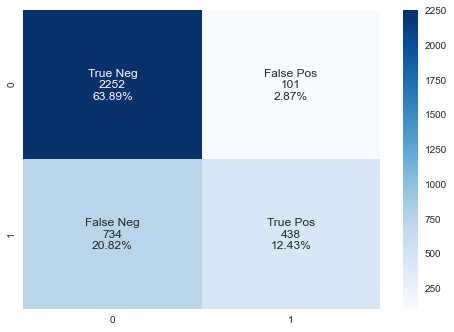

In [97]:
# Get Predictions
predictions = predict_model(offensive_catboost, data=count_vect_df, probability_threshold=0.5, raw_score=True)

# Run Report
report(predictions['Offensive'], predictions['Label'])

## Putting The Whole Pipeline Together

Now I will put together a full pipeline that takes a chat message and indicates whether it is hateful, offensive, and/or contains profanity.

In [127]:
def pipeline(hate_model, offensive_model, hate_vectorizer, offensive_vectorizer, profanity, message):
    def preprocess(message):
        # Remove Numbers
        message = re.sub(r'\d+', '', message)
        # Remove Punctuation
        message = "".join([i for i in message if i not in string.punctuation])
        return message
    
    
    def check_hate(hate_model, hate_vectorizer, message):
        hate_vec = hate_vectorizer.transform([message])
        count_vect_df = pd.DataFrame(hate_vec.todense(), columns=hate_vectorizer.get_feature_names())
        prediction = predict_model(hate_model, data=count_vect_df, probability_threshold=0.5, raw_score=True)
        return prediction['Score_1'][0]
    
    
    def check_offensive(offensive_model, offensive_vectorizer, message):
        off_vec = offensive_vectorizer.transform([message])
        count_vect_df = pd.DataFrame(off_vec.todense(), columns=offensive_vectorizer.get_feature_names())
        prediction = predict_model(offensive_model, data=count_vect_df, probability_threshold=0.5, raw_score=True)
        return prediction['Score_1'][0]
    
    
    def check_profanity(profanity, message):
        message_words = message.split()
        profane_words = []
        for word in message_words:
            if word in list(profanity['Word']):
                profane_words.append(word)
        return profane_words
    
    message = preprocess(message)
    hate_score = check_hate(hate_model, hate_vectorizer, message)
    offensive_score = check_offensive(offensive_model, offensive_vectorizer, message)
    profane_words = check_profanity(profanity, message)
    
    return hate_score, offensive_score, profane_words

In [149]:
hate_model = load_model('catboost_hate_model')
offensive_model = load_model('catboost_offensive_model')
profanity = pd.read_csv('Data/profanity.csv')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


### Example Output

In [156]:
message = 'This is a lovely service'

hate_score, offensive_score, profane_words = pipeline(hate_model, offensive_model,
                                                      hate_vectorizer, offensive_vectorizer,
                                                      profanity, message)

print(message)
print('Hate Score: {:.0%}'.format(hate_score))
print('Offensive Score: {:.0%}'.format(offensive_score))
if len(profane_words) == 0:
    print('No Profanity')
else:
    print('Profane Words: {}'.format(len(profane_words)))

This is a lovely service
Hate Score: 23%
Offensive Score: 22%
No Profanity


### Testing on Customer Service Messages

For a final evaluation we use a free customer service message corpus from BiText. This will allow us to test the models on more than just tweets. I labeled 299 messages for whether or not they contained hate speech, offensive speech, or profanity. The sample did not have hate messages and only had 13 offensive messages which contained profanity. However, this will test the method for false positive, which should be avoided. The business would not want to block a customer without reason.

In [165]:
bitext_df = pd.read_csv('Data/bitext_free_dataset_labeled_sample.csv')
print(bitext_df.shape)
print('Hate Messages: {:.0%}'.format((bitext_df.shape[0]-bitext_df.hate.value_counts()[0])/bitext_df.shape[0]))
print('Offensive Messages: {:.0%}'.format((bitext_df.shape[0]-bitext_df.offensive.value_counts()[0])/bitext_df.shape[0]))
print('Messages with Profanity: {:.0%}'.format((bitext_df.shape[0]-bitext_df.profanity.value_counts()[0])/bitext_df.shape[0]))
bitext_df.head()

(299, 6)
Hate Messages: 0%
Offensive Messages: 4%
Messages with Profanity: 4%


,utterance,category,intent,hate,offensive,profanity
0,"I'm not happy with the service, what do I have...",FEEDBACK,complaint,0,0,0
1,do you mind asking Alexa how I could check my ...,ORDER,track_order,0,0,0
2,"ask alexa how to call customer supoort, please",CONTACT,contact_customer_service,0,0,0
3,"I have an issue making a payment, how can I re...",PAYMENT,payment_issue,0,0,0
4,can u ask alexa where to see the cancellation ...,CANCELLATION_FEE,check_cancellation_fee,0,0,0


In [170]:
hate_scores = []
offensive_scores = []
profanity_present = []
for message in bitext_df.utterance:
    hate_score, offensive_score, profane_words = pipeline(hate_model, offensive_model,
                                                      hate_vectorizer, offensive_vectorizer,
                                                      profanity, message)
    hate_scores.append(hate_score)
    offensive_scores.append(offensive_score)
    if len(profane_words) == 0:
        profanity_present.append(0)
    else:
        profanity_present.append(1)

        
bitext_df['hate_score'] = hate_scores
bitext_df['offensive_score'] = offensive_scores
bitext_df['profanity_present'] = profanity_present

In [194]:
bitext_df.head()

,utterance,category,intent,hate,offensive,profanity,hate_score,offensive_score,profanity_present
0,"I'm not happy with the service, what do I have...",FEEDBACK,complaint,0,0,0,0.0,0.0,0
1,do you mind asking Alexa how I could check my ...,ORDER,track_order,0,0,0,0.0,0.0,0
2,"ask alexa how to call customer supoort, please",CONTACT,contact_customer_service,0,0,0,0.0,0.0,0
3,"I have an issue making a payment, how can I re...",PAYMENT,payment_issue,0,0,0,0.0,0.0,0
4,can u ask alexa where to see the cancellation ...,CANCELLATION_FEE,check_cancellation_fee,0,0,0,0.0,0.0,0


#### Hate Prediction Results

In [191]:
threshold = 0.5
hate_predictions = bitext_df['hate_score']
hate_predictions[hate_predictions >= threshold] = 1
hate_predictions[hate_predictions < threshold] = 0
accuracy = accuracy_score(bitext_df['hate'], hate_predictions)
print('Accuracy: {:.1%}'.format(accuracy))

Accuracy: 100.0%


#### Offensive Prediction Results

In [192]:
threshold = 0.5
offensive_predictions = bitext_df['offensive_score']
offensive_predictions[offensive_predictions >= threshold] = 1
offensive_predictions[offensive_predictions < threshold] = 0
accuracy = accuracy_score(bitext_df['offensive'], offensive_predictions)
print('Accuracy: {:.1%}'.format(accuracy))

Accuracy: 100.0%


#### Profanity Detection Results

In [193]:
accuracy = accuracy_score(bitext_df['profanity'], bitext_df['profanity_present'])
print('Accuracy: {:.1%}'.format(accuracy))

Accuracy: 100.0%


In this test the models and list of profanity words were able to detect the 13 abusive chats with 100% accuracy. However, this is just a small test on a free dataset for a proof of concept. The models would likely need to be trained and tested on actual company data at a much larger scale.